In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
file_path = 'data/JOG_monthly.csv'
df = pd.read_csv(file_path, delimiter=';')
df['Date'] = pd.to_datetime(df['THBL'], format='%Y%m')
df.set_index('Date', inplace=True)
df = df.asfreq('MS')
scaler = MinMaxScaler()
df['GWH_JUAL'] = scaler.fit_transform(df[['GWH_JUAL']].dropna())
df.drop(columns='THBL', inplace=True)
print(df.head())

            GWH_JUAL
Date                
2015-01-01  0.094838
2015-02-01  0.000000
2015-03-01  0.115178
2015-04-01  0.115373
2015-05-01  0.162993


In [3]:
ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle=False)
ts_train.shape, ts_test.shape

((90, 1), (23, 1))

# Fitur Lag untuk Model OLS

In [20]:
def create_lagged_features(data, lag=4):
    df_lagged = pd.DataFrame(index=data.index)
    df_lagged['y'] = data
    for i in range(1, lag+1):
        df_lagged[f'lag_{i}'] = data.shift(i)
    df_lagged.dropna(inplace=True)
    return df_lagged

# Tentukan lag yang ingin digunakan (misalnya lag 1)
lag = 4
train_lagged = create_lagged_features(ts_train['GWH_JUAL'], lag)
test_lagged = create_lagged_features(ts_test['GWH_JUAL'], lag)

In [21]:
# Memisahkan fitur dan target
X_train = train_lagged.drop(columns='y')
y_train = train_lagged['y']
X_test = test_lagged.drop(columns='y')
y_test = test_lagged['y']

# Membuat dan melatih model OLS
model = LinearRegression()
model.fit(X_train, y_train)

# Prediksi
y_pred = model.predict(X_test)

In [22]:
def mean_absolute_percentage_error(targets, preds):
    targets = np.array(targets)
    preds = np.array(preds)
    return np.mean(np.abs((targets - preds) / targets)) * 100

def symmetric_mean_absolute_percentage_error(targets, preds):
    targets = np.array(targets)
    preds = np.array(preds)
    return np.mean(2.0 * np.abs(preds - targets) / (np.abs(targets) + np.abs(preds))) * 100

Metrics for Test Data:
MAE  : 0.0843
MSE  : 0.0135
R²   : 0.2852
MAPE : 10.8538%
SMAPE: 11.8184%


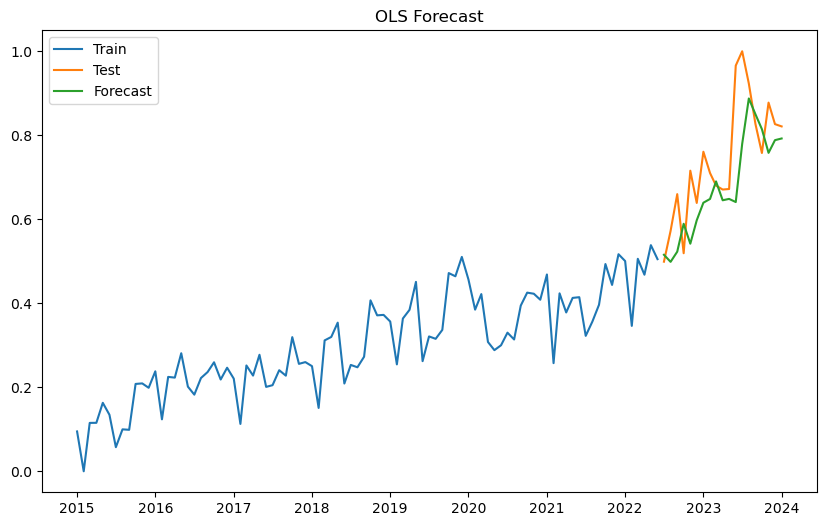

In [23]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
smape = symmetric_mean_absolute_percentage_error(y_test, y_pred)

print("Metrics for Test Data:")
print(f"MAE  : {mae:.4f}")
print(f"MSE  : {mse:.4f}")
print(f"R²   : {r2:.4f}")
print(f"MAPE : {mape:.4f}%")
print(f"SMAPE: {smape:.4f}%")

plt.figure(figsize=(10, 6))
plt.plot(ts_train.index, ts_train['GWH_JUAL'], label='Train')
plt.plot(ts_test.index[:len(y_test)], y_test, label='Test')
plt.plot(ts_test.index[:len(y_pred)], y_pred, label='Forecast')
plt.title('OLS Forecast')
plt.legend()
plt.show()